In [17]:
# astropy is a useful library for doing analysis on astronomical data.
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import WMAP9 as cosmo

# pass SQL queries to CasJobs as strings
from SciServer import CasJobs


from matplotlib import rcParams, cm
from matplotlib import pyplot as pp
import numpy as np

rcParams['figure.figsize'] = [10.0, 10.0]
rcParams['font.size'] = 20

cmap = cm.get_cmap('viridis')
colors=[cmap(0),cmap(75),cmap(150),cmap(225)]

# __Classification with multi-wavelength photometry__

We spoke about two types of data acquisition in astronomy

- Photometry

photography of the sky through broadband filters to obtain a crude measurement of the slope of a source spectrum.

- Spectroscopy

photography of the sky through a dispersing element to produce a high-resolution spectrum.

Spectra contain a huge amount of information, whereas the information content of photometry is limited. Nevertheless, photometry is popular because light collection through broadband filters is much more efficient than through narrow spectral channels. Typically, astronomers use photometry to classify and characterize large numbers of sources and then follow up the most interesting of them with spectroscopy.

The following example shows the power of multi-wavelength photometry in source classification. Here I am querying a positionally matched table which contains both optical an mid-infrared photometry from two different sky surveys. All the objects in this table have been spectroscopically identified and have been classified as either a GALAXY, STAR OR QSO

In [155]:
# query the cross matched catalog at random
query = "SELECT TOP 1 PERCENT * FROM mydb.SDSSXWISE ORDER BY NEWID()" 
data = CasJobs.executeQuery(query, "mydb")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28016 entries, 0 to 28015
Data columns (total 6 columns):
s_psfMag_g    28016 non-null float64
s_psfMag_r    28016 non-null float64
s_psfMag_i    28016 non-null float64
w_w1mpro      28016 non-null float64
w_w2mpro      28016 non-null float64
s_class       28016 non-null object
dtypes: float64(5), object(1)
memory usage: 1.3+ MB


Here the fields s_psfMag_g, r and i refer to the measured flux through three optical broadband filters. The fields w_w1mpro and w_w2mpro refer to the flux through two mid-infrared filters. The field s_class stores the spectroscopic classification for each object.

Below I'm plotting the ratio of fluxes through different broadband filters. The left-hand plot shows optical filters, r:i vs g:r. In this space, it would be reasonably easy to identify a region containing galaxies and QSOs but each sample would contain significant contamination from stars. The right plot shows the utility of multi-wavelength photometry in classification. Here I've replaced r:i for i:W1. In comparison to galaxies and quasars, stellar spectra are skewed toward redder wavelengths and now one could easily draw a decision boundary that classifies the majority of stars, galaxies, and quasars correctly.

For more difficult problems one could easily include more multi-wavelength data. We could also include morphological information, for instance, we know galaxies are extended on the sky whereas stars and quasars are point-like. We can add priors, since we know that the space density of quasars is much lower than for stars or galaxies i.e. in picking any astronomical object at random it's much more likely to be a star or galaxy than it is a quasar.


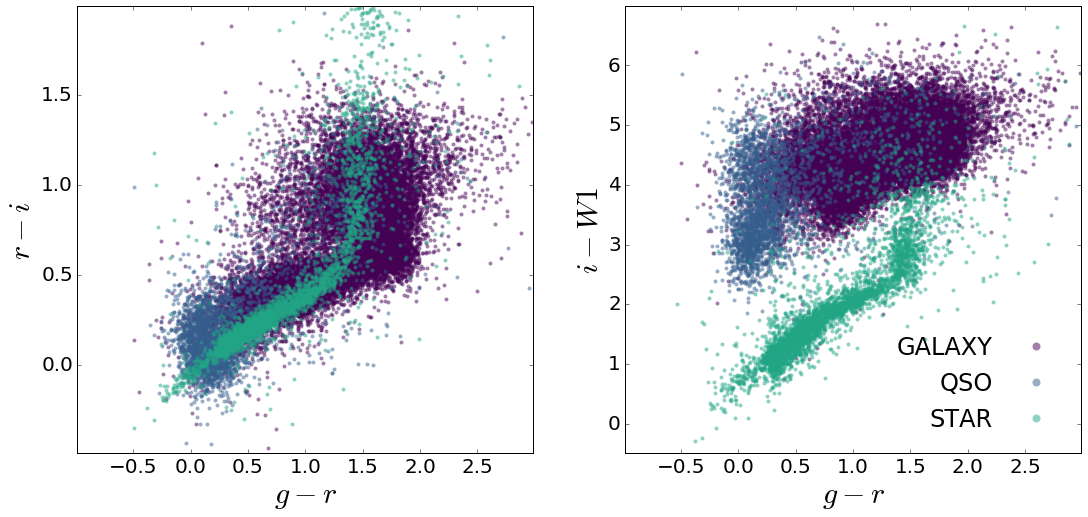

In [72]:
# color-color plot gr:ri and gr:i-W1 stars, galaxies, qsos
pp.figure(figsize=(18,8))
ax1 = pp.subplot(121)
ax2 = pp.subplot(122)
stype=['GALAXY','QSO','STAR']
for typ, col in zip(stype,colors):
    I=data.s_class==typ
    subcat=data[I]
    ax1.plot(subcat.s_psfMag_g-subcat.s_psfMag_r,
            subcat.s_psfMag_r-subcat.s_psfMag_i,
            marker='o',markersize=4,markeredgecolor='none',linestyle='',label=typ,color=col,alpha=0.5)
    ax2.plot(subcat['s_psfMag_g']-subcat['s_psfMag_r'],
            subcat['s_psfMag_i']-subcat['w_w1mpro'],
            marker='o',markersize=4,markeredgecolor='none',linestyle='',label=typ,color=col,alpha=0.5)

# plot layout    
ax1.set_xlim(-0.99,2.99); ax1.set_ylim(-0.49,1.99)
ax1.set_xlabel('$g-r$',fontsize=30); ax1.set_ylabel('$r-i$',fontsize=30)
ax2.set_xlim(-0.99,2.99); ax2.set_ylim(-0.49,6.99)
ax2.set_xlabel('$g-r$',fontsize=30); ax2.set_ylabel('$i-W1$',fontsize=30)
ax2.legend(markerscale=2,numpoints=1,loc=4,frameon=False,markerfirst=False)

# Gaussian Mixture Model for Unsupervised Galaxy Classification

Within the galaxy population, there are a large variety of subclasses, many of which overlap. An example of this is star-forming galaxies vs. active galactic nuclei (AGN). The distinction between these two subclasses concerns the mechanisms by which their spectra are generated. In star-forming galaxies, star formation is responsible for most of the emission, whereas in active galaxies emission associated with material falling onto a black hole plays a significant role.

The Baldwin-Phillips-Terlevich (BPT) and WHAN diagrams aim to classify these different subclasses by using the relative strength of emission associated with ionized Oxygen, Nitrogen, and Hydrogen. 

The dataset used here has been compiled by Dr. Pierre-Yves Lablanche and this example is based on his classes on Machine learning in astronomy here https://github.com/astro4dev/OAD-Data-Science-Toolkit

First, we import his data-set then we plot the BPT and WHAN diagrams, left and right respectively. Traditionally hard cuts like those overplotted on the BPT diagram are used to select star-forming and AGN galaxies. How far can we get with Gaussian Mixture Models?

In [157]:
# query Dr. Pierre-Yves Lablanche's bpt data set
query ="SELECT * FROM GMMBPT"
result = CasJobs.executeQuery(query, "mydb")
result[0:5]

,plate,mjd,fiber_id,xx_BPT_WHAN,yy_BPT,yy_WHAN
0,266,51602,1,-0.326378,-0.103575,0.743510
1,266,51602,6,-0.513446,-0.451692,1.479042
2,266,51602,12,-0.435814,-0.469374,1.166963
3,266,51602,17,-0.295548,-0.235745,0.687440
4,266,51602,33,-0.210833,-0.287712,1.144792


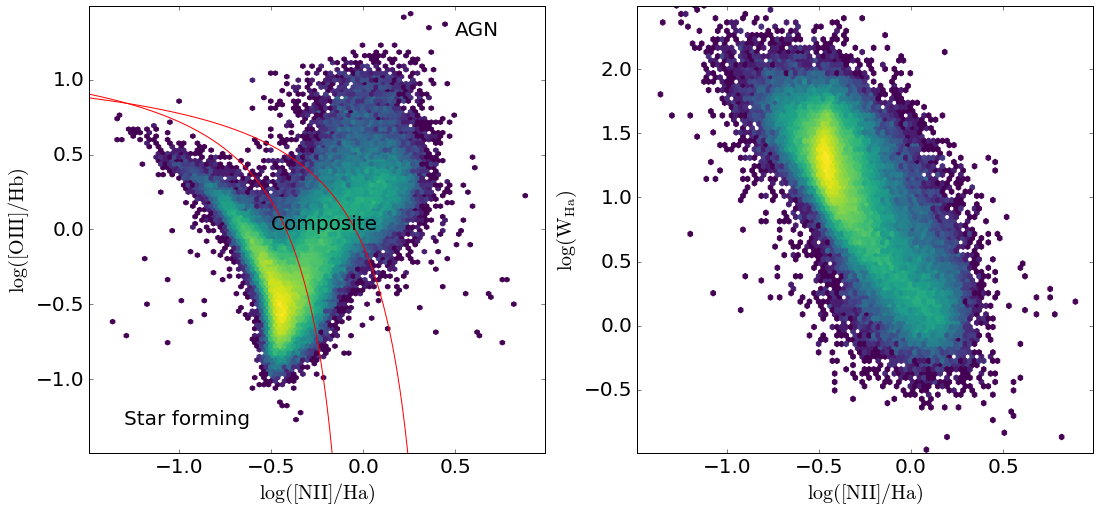

In [167]:
# The BPT and WHAN diagrams
pp.figure(figsize=(18,8))

ax1 = pp.subplot(121)
result.plot.hexbin(x='xx_BPT_WHAN', y='yy_BPT', mincnt=1,
                 bins='log', gridsize=101, cmap='viridis', ax=ax1,colorbar=False)

ax2 = pp.subplot(122)
result.plot.hexbin(x='xx_BPT_WHAN', y='yy_WHAN', mincnt=1,
                 bins='log', gridsize=101, cmap='viridis', ax=ax2,colorbar=False)

# star forming galaxies
sfmcut=0.61/(np.arange(-1.5,-0.1,0.01) - 0.05) + 1.30
# AGN
agncut=0.61/(np.arange(-1.5,0.3,0.01) - 0.47) + 1.19 

# plot and layout
ax1.plot(np.arange(-1.5,-0.1,0.01),sfmcut,color='red')
ax1.plot(np.arange(-1.5,0.3,0.01),agncut,color='red')             
ax1.set_xlim(-1.49,0.99); ax1.set_ylim(-1.49,1.49)
ax2.set_xlim(-1.49,0.99); ax2.set_ylim(-0.99,2.49)
ax1.set_xlabel('$\mathrm{log( [NII]/Ha )}$')
ax1.set_ylabel('$\mathrm{log( [OIII]/Hb )}$')
ax1.text(-1.3,-1.3,'Star forming')
ax1.text(0.5,1.3,'AGN')
ax1.text(-0.5,0.0,'Composite')
ax2.set_xlabel('$\mathrm{log( [NII]/Ha )}$')
ax2.set_ylabel('$\mathrm{log( W_{Ha} )}$')

In [5]:
# can we model this as a mixture of Gaussians?
from sklearn.mixture import GMM

# define and train GMM
gmm = GMM(covariance_type='full', n_components=4)
gmm.fit(result[['xx_BPT_WHAN','yy_BPT','yy_WHAN']])

# return the probability of belonging to a group
proba = gmm.predict_proba(result[['xx_BPT_WHAN','yy_BPT','yy_WHAN']])
labels = proba.argmax(axis=1)

# add to the initial dataframe new columns
# containing the probability to belong to a group
result['gmm3_proba1'] = proba_gmm[:,0]
result['gmm3_proba2'] = proba_gmm[:,1]
result['gmm3_proba3'] = proba_gmm[:,2]
result['gmm3_proba4'] = proba_gmm[:,3]
result[0:5]

,plate,mjd,fiber_id,xx_BPT_WHAN,yy_BPT,yy_WHAN,gmm3_proba1,gmm3_proba2,gmm3_proba3,gmm3_proba4
0,266,51602,1,-0.326378,-0.103575,0.743510,0.000389,0.059396,0.009714,0.930501
1,266,51602,6,-0.513446,-0.451692,1.479042,0.015360,0.000161,0.934037,0.050442
2,266,51602,12,-0.435814,-0.469374,1.166963,0.021724,0.000298,0.837572,0.140406
3,266,51602,17,-0.295548,-0.235745,0.687440,0.001038,0.030324,0.008483,0.960155
4,266,51602,33,-0.210833,-0.287712,1.144792,0.037172,0.019494,0.018357,0.924977


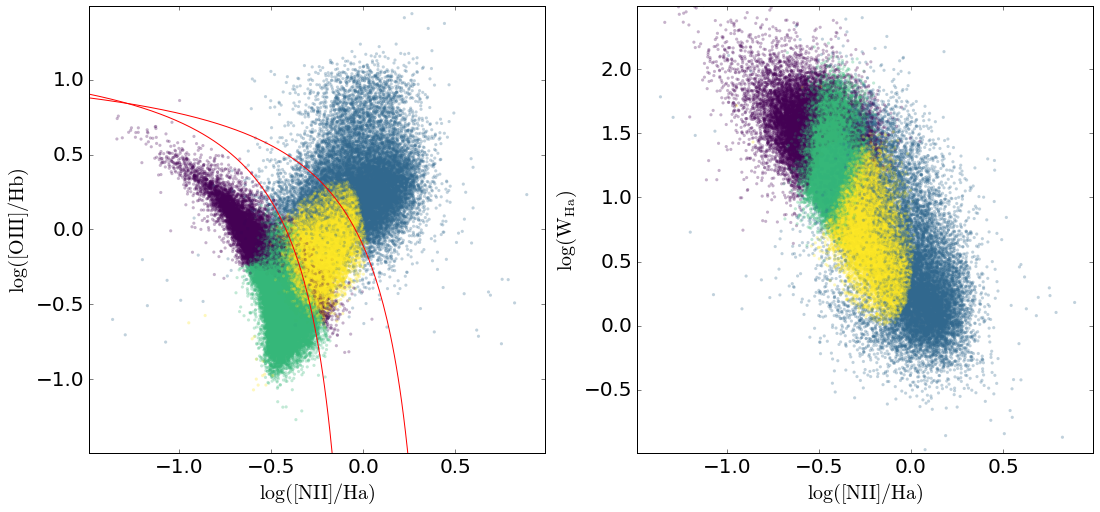

In [159]:
# plot and layout
pp.figure(figsize=(18,8))
ax1 = pp.subplot(121)
ax2 = pp.subplot(122)
ax1.scatter(result.xx_BPT_WHAN, result.yy_BPT, c=labels, s=10, cmap=cmap, edgecolors='none',alpha=0.3)
ax2.scatter(result.xx_BPT_WHAN, result.yy_WHAN, c=labels, s=10, cmap=cmap, edgecolors='none',alpha=0.3)
ax1.plot(np.arange(-1.5,-0.1,0.01),sfmcut,color='red')
ax1.plot(np.arange(-1.5,0.3,0.01),agncut,color='red')             
ax1.set_xlim(-1.49,0.99); ax1.set_ylim(-1.49,1.49)
ax2.set_xlim(-1.49,0.99); ax2.set_ylim(-0.99,2.49)
ax1.set_xlabel('$\mathrm{log( [NII]/Ha )}$')
ax1.set_ylabel('$\mathrm{log( [OIII]/Hb )}$')
ax2.set_xlabel('$\mathrm{log( [NII]/Ha )}$')
ax2.set_ylabel('$\mathrm{log( W_{Ha} )}$')

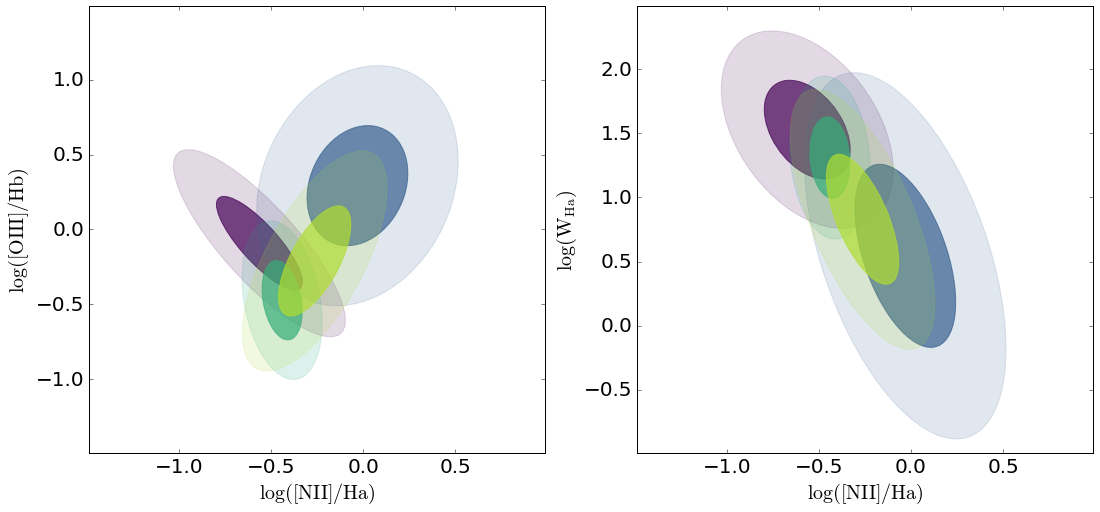

In [60]:
# plot 68% and 95% confidence intervals of the fitted gaussians.
from bptellipse import BPT_ell, WHAN_ell
pp.figure(figsize=(18,8))

ax1 = pp.subplot(121)
for i, c in enumerate(colors):
    BPT_ell(gmm.covars_[i], gmm.means_[i], ax=ax1, col=c)

ax2 = pp.subplot(122)
for i, c  in enumerate(colors):
    WHAN_ell(gmm.covars_[i], gmm.means_[i], ax=ax2, col=c)

ax1.set_xlim(-1.49,0.99); ax1.set_ylim(-1.49,1.49)
ax2.set_xlim(-1.49,0.99); ax2.set_ylim(-0.99,2.49)
ax1.set_xlabel('$\mathrm{log( [NII]/Ha )}$')
ax1.set_ylabel('$\mathrm{log( [OIII]/Hb )}$')
ax2.set_xlabel('$\mathrm{log( [NII]/Ha )}$')
ax2.set_ylabel('$\mathrm{log( W_{Ha} )}$')

This is a "toy" example of how one might begin to classify galaxies. For a much more physically motivated model using the same approah see this paper by R. S. de Souza et al. https://arxiv.org/pdf/1703.07607.pdf

# A Slice through the Universe

One of the many benefits of obtaining spectroscopy over photometry is that objects like galaxies move through space, their spectra are Doppler shifted and contain velocity information, which can be used to determine the distance to the emitting source (see the next section). The SDSS (Sloan Digital Sky Survey) contains around 10 million spectra of stars galaxies and quasars. Below I am querying the SDSS for galaxies with spectra over a small range in Declination (the celestial equivalent of longitude) and pulling back the Doppler parameter z (known as redshift).

From this, I am able to plot the distance to each galaxy in a slice through the Universe. Since light travels at a finite speed, distance translates to a light travel time so I can replace the radial distance axis with time in Gyr. Notice how the galaxy distribution clusters together under the influence of gravity.

In [174]:
# query a large R.A. range small Dec. range
query = """SELECT s.z, p.ra, p.dec
FROM specObj AS s 
JOIN photoObj AS p 
ON s.BestObjID=p.ObjID 
WHERE 
p.dec>=10.0 AND p.dec<=11 AND 
s.class='GALAXY' AND 
s.zwarning=0 AND 
p.modelmag_r > 13 AND 
s.z<0.3""" 
result = CasJobs.executeQuery(query, "DR14")
result[0:5]

,z,ra,dec
0,0.086933,323.764055,10.529867
1,0.136480,320.193948,10.231683
2,0.137991,320.255500,10.241972
3,0.086210,321.230934,10.807250
4,0.137481,316.648790,10.294063


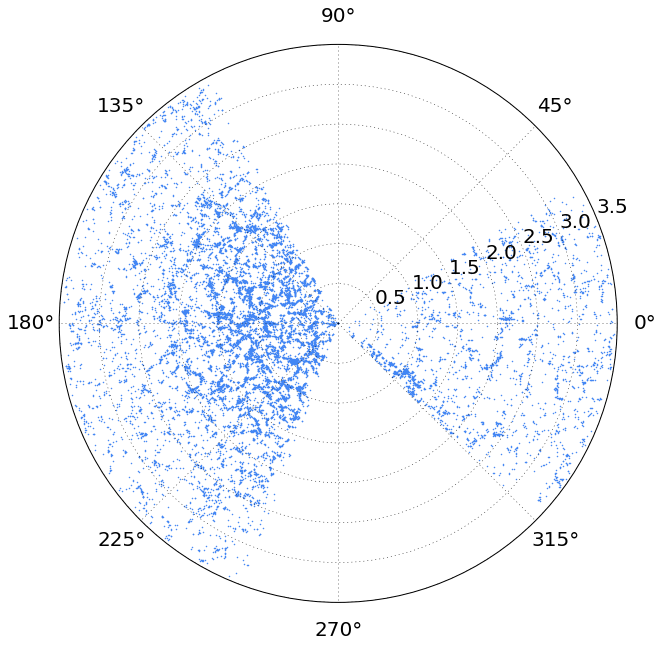

In [17]:
# collapse in Dec. and plot R.A. as a function of lookback time
ax = pp.axes(projection='polar')
time=cosmo.age(result['z']) # age of universe at given distance
ax.plot(result.ra * np.pi/180., cosmo.age(0.)-time, color='#4286f4', 
        markeredgecolor='#4286f4', marker='o', markersize=1, linestyle='')

# The Hubble Constant

Here we recreate a simple but classic 100-year-old experiment first conducted by Edwin Hubble. His results served as the catalyst to the development of the Big-Bang theory. Below I am querying the SDSS database for a bunch of the brightest galaxies on the sky. I've placed the results in a google sheet 

https://docs.google.com/spreadsheets/d/1PlqqBLDxdBaI9k-BKa2uBBNxeUNhIgnopHSOKHSSOxs/edit?usp=sharing

select and copy the columns named z, RA, and DEC here

http://cas.sdss.org/dr14/en/tools/chart/listinfo.aspx

In groups, pick 5 galaxies and measure the coordinates (R.A. and Dec.) at the extreme edges of each galaxy. Make sure you measure along the semi-major axis. Input your results in the google sheet linked above. From your results, we'll measure the angular distance of each galaxy on the sky



In [175]:
# select a bunch of nearby bright starforming galaxies
query = "SELECT TOP 25 s.z, p.ra, p.dec \
FROM specObj AS s \
JOIN photoObj AS p \
ON s.BestObjID=p.ObjID \
WHERE  \
s.class='GALAXY' AND \
s.subclass='STARFORMING' AND \
s.zwarning=0 AND \
p.modelmag_r > 13 AND \
s.z<0.03 \
ORDER BY p.modelmag_r"
result = CasJobs.executeQuery(query, "DR14")

At this point, I've uploaded your results into the SciServer and below I am querying the table

In [176]:
query = "SELECT z, RA_1, DEC_1, RA_2, DEC_2 \
FROM GalaxyData"
result = CasJobs.executeQuery(query, "mydb")

query = "SELECT z, RA_1, DEC_1, RA_2, DEC_2 \
FROM GalaxyData2"
result2 = CasJobs.executeQuery(query, "mydb")
result=result.append(result2)


Using the small angle formula and assuming the average physical size of galaxies is $\mathrm{0.022\, \mathrm{Mpc}}$ (where $\mathrm{Mpc=3\times10^{19}}\,\mathrm{km}$) we can calculate the distance to each of the galaxies using the coordinates you measured.

In [177]:
from astropy.constants import c # speed of light m/s
z=result.z

# angle subtended by each galaxy on the sky
coo1=SkyCoord(ra=result['RA_1']*u.degree,dec=result['DEC_1']*u.degree)
coo2=SkyCoord(ra=result['RA_2']*u.degree,dec=result['DEC_2']*u.degree)
angSize=coo1.separation(coo2).radian
# distance to object using small angle approximation 
d=0.022/angSize # Mpc

Galaxies move through space and their spectra a Doppler shifted. The Doppler parameter $z$ or "redshift" is given by $\frac{\lambda_{obs}-\lambda_{rest}}{\lambda_{rest}}$, i.e. the difference between the observed wavelength $\lambda_{obs}$ and the rest wavelength $\lambda_{rest}$ over the rest wavelength. $z$ is known for all the galaxies you have just analyzed and the velocity of each is given by $v=cz$.

In [179]:
# doppler velocity z=v/c
v=z*c.value/1000. # km/s

Hubble then plotted velocity vs. distance and found a positive correlation

R = 0.678106237942


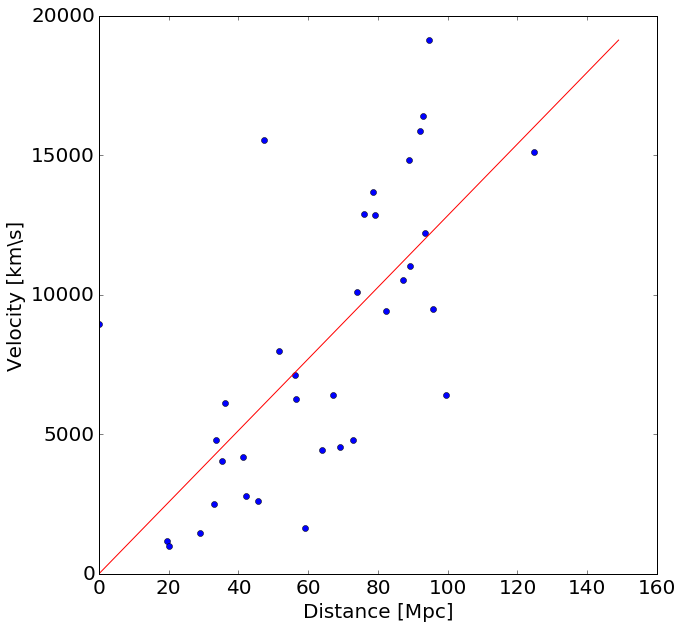

In [183]:
# plot results
pp.plot(d, v, 'o', linestyle='')

pp.xlabel('Distance [Mpc]')
pp.ylabel('Velocity [km\s]')

# correlation coefficient
d=np.squeeze(d)
R=np.sum( (d-d.mean()) * (v-v.mean()) )/( np.sum((d-d.mean())**2)**0.5 * np.sum((v-v.mean())**2)**0.5 )
print("R =",R)
# fit a regression line
d = d[:,np.newaxis]
a, _, _, _ = np.linalg.lstsq(d, v)
x=np.arange(0,150.)
pp.plot(x, a*x, 'r-')

So more distant galaxies are moving at a greater velocity. What is interesting here is that there are no negative velocities, refer back to the definition of $z$ above. Galaxies moving towards us should be blueshifted i.e. $\lambda_{obs} < \lambda_{rest}$. So not only are more distant galaxies moving faster through space, they are also all moving away from us.

This suggests that the Universe might be expanding, but the implication is deeper than that. Imagine for example we were sitting at the center of an expanding Universe, like being at the center of an explosion. This would not require a correlation between distance and velocity. Galaxies around us could be moving at a constant speed at all distances and we could still have an expanding Universe.

The deeper implication, one that requires a correlation between distance and velocity, is that the space between galaxies is expanding, such that all galaxies are moving away from all others. Imagine charting our position in the Universe on a grid. The closest galaxy to ours is one grid cell away and the space between us is expanding at a rate of 2 km/s, therefore that galaxy has a recession velocity of 2 km/s with respect to us. The next closest galaxy to ours is two grid cells away in the same direction. If the space between each grid cell is expanding at a rate of 2 km/s then that galaxy has a recession velocity of 4 km/s with respect to us. The next closest galaxy has a recession velocity of 6 km/s and so on...

Let's now look at the gradient of fit to the above plot. The gradient is the ratio of a change in velocity to a change in distance i.e. it has units 

$\mathrm{km\,s^{-1}\,Mpc^{-1}}$,

where $1 \mathrm{Mpc}$ is $3\times10^{19}\mathrm{km}$

This is known as the Hubble constant, $Ho$, and is the rate of the expansion of space. For a gradient $m$, each $\mathrm{Mpc}$ of space is expanding at a rate of $m\, \mathrm{km\,s^{-1}}$. Hubble measured a value of $Ho\approx 600\mathrm{km\,s^{-1}\,{Mpc^{-1}}}$. The modern accepted value is closer to $70\mathrm{km\,s^{-1}\,{Mpc^{-1}}}$. The value we measured is

In [184]:
print("Ho =",a[0])

Ho = 128.386633054


The gradient can also be recast as an inverse time

$$\frac{\mathrm{km}}{\mathrm{s}}\frac{1}{\mathrm{Mpc}}=\frac{\mathrm{km}}{\mathrm{s}}\frac{1}{3\times10^{19}\,\mathrm{km}}$$

This time is the age of the Universe $\approx\,13.8\mathrm{Gyr}$

# Photometric redshifts
The Doppler parameter $z$ or redshift is an important quantity in astronomy. As we've seen above it allows us to measure the velocities, distances, and ages of astronomical objects. We'd like to know the redshifts of every extra-galactic object we survey but obtaining spectra for all these objects is out of the question. There is a lot of effort towards making redshift measurements with photometric data. Here I train the nearest neighbor model on photometric data and known spectroscopic redshifts to be able to predict redshift based solely of photometry.

This is a problem usually solved using artificial neural networks but the KNN approach does remarkably well. This is adapted from an example given here http://www.astroml.org/

In [25]:
from io import StringIO
from sklearn.neighbors import KNeighborsRegressor
from astroML.plotting import scatter_contour

In [26]:
# query quasars and galaxies
NOBJECTS = 20000
query_text = ('\n'.join(
    ("SELECT TOP %i" % NOBJECTS,
    "   p.u, p.g, p.r, p.i, p.z, s.z, s.zerr",
    "FROM PhotoObj AS p",
    "   JOIN SpecObj AS s ON s.bestobjid = p.objid",
    "WHERE ",
    "   p.u BETWEEN 0 AND 19.6",
    "   AND p.g BETWEEN 0 AND 20",
    "   AND (s.class = 'GALAXY' OR s.class = 'QSO')")))
response = CasJobs.executeQuery(query_text, "DR12", format="csv")

In [27]:
# load data into arrays
output = StringIO(response)
GAL_COLORS_DTYPE = [('u', float),
                    ('g', float),
                    ('r', float),
                    ('i', float),
                    ('z', float),
                    ('redshift', float),
                    ('redshift_err', float)]
data = np.loadtxt(output, delimiter=',',skiprows=1, dtype=GAL_COLORS_DTYPE)

N = len(data)
# shuffle data
np.random.seed(0)
np.random.shuffle(data)
# put colors in a matrix
X = np.zeros((N, 4))
X[:, 0] = data['u'] - data['g']
X[:, 1] = data['g'] - data['r']
X[:, 2] = data['r'] - data['i']
X[:, 3] = data['i'] - data['z']
z = data['redshift']
# divide into training and testing data
Ntrain = N // 2
Xtrain = X[:Ntrain]
ztrain = z[:Ntrain]
Xtest = X[Ntrain:]
ztest = z[Ntrain:]

# KNN 
n_neighbors = 1
knn = KNeighborsRegressor(n_neighbors, weights='uniform')
zpred = knn.fit(Xtrain, ztrain).predict(Xtest)
rms = np.sqrt(np.mean((ztest - zpred) ** 2))
print("RMS error = %.2g" % rms)

RMS error = 0.34


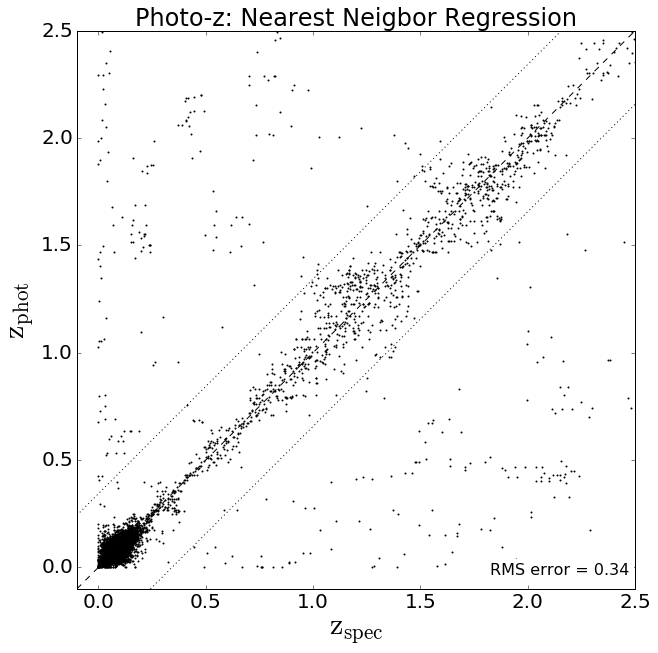

In [30]:
# plot results
axis_lim = np.array([-0.1, 2.5])
ax = pp.axes()
pp.scatter(ztest, zpred, c='k', lw=0, s=4)
pp.plot(axis_lim, axis_lim, '--k')
pp.plot(axis_lim, axis_lim + rms, ':k')
pp.plot(axis_lim, axis_lim - rms, ':k')
pp.xlim(axis_lim)
pp.ylim(axis_lim)
pp.text(0.99, 0.02, "RMS error = %.2g" % rms,
         ha='right', va='bottom', transform=ax.transAxes,
         bbox=dict(ec='w', fc='w'), fontsize=16)
pp.title('Photo-z: Nearest Neigbor Regression')
pp.xlabel(r'$\mathrm{z_{spec}}$', fontsize=30)
pp.ylabel(r'$\mathrm{z_{phot}}$', fontsize=30)